In [4]:
import numpy as np
import pandas as pd
import scipy.io as sio # for loading MATLAB files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter, filtfilt, iirnotch, sosfiltfilt, welch

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os
from scipy.signal import resample
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt
#test

## Ninapro dataset

In [5]:
data_DB3_s1_E1 = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
print(f"What kind of data structure are we working with? {type(data_DB3_s1_E1)}")
print(f"What are the keys of the data structure? \n{[key for key in data_DB3_s1_E1.keys()]}")

What kind of data structure are we working with? <class 'dict'>
What are the keys of the data structure? 
['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'glove', 'inclin', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition']


In [6]:
emg = data_DB3_s1_E1["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))

EMG data dimension: (1825008, 12)
EMG data type: <class 'numpy.ndarray'>


In [7]:
## !! stimulus -> restimulus !!
emg_rectified = data_DB3_s1_E1["emg"].copy()

#Stimulus is the type of movement that is being performed
stimulus = data_DB3_s1_E1["stimulus"] 
#Repetition is the number of times the movement has been repeated
repetition = data_DB3_s1_E1["repetition"] 

#Restimulus and rerepetition are the stimulus and repetition that have been processed for better correspondance to real movement
restimulus = data_DB3_s1_E1['restimulus']
rerepetition = data_DB3_s1_E1['rerepetition']

print(f'What are the shape of the data that we are working with? \nEMG: {emg_rectified.shape}, \nStimulus {stimulus.shape}, \nRepetition {repetition.shape}, \nRestimulus {restimulus.shape}, \nRerepetition {rerepetition.shape}')

# -1 because 0 is the resting condition
n_stimuli = len(np.unique(restimulus)) - 1 
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(rerepetition)) - 1 
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}') 
print(np.unique(restimulus))
print(f'How many repetitions are there? {n_repetitions}') 

number_of_samples_per_trial = np.zeros((n_stimuli+1, n_repetitions))

for stimuli_idx in range(n_stimuli+1): # include the resting condition
    for repetition_idx in range(n_repetitions):
        
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

print("Nb of samples for each trial")
number_of_samples_per_trial

What are the shape of the data that we are working with? 
EMG: (1825008, 12), 
Stimulus (1825008, 1), 
Repetition (1825008, 1), 
Restimulus (1825008, 1), 
Rerepetition (1825008, 1)
How many types of movement are there? 17
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
How many repetitions are there? 5
Nb of samples for each trial


array([[125449., 110944., 120097., 122974., 123594.],
       [ 14027.,  12808.,  13026.,  13044.,  12950.],
       [ 13026.,  13082.,  13224.,  12948.,  13027.],
       [ 12969.,  12968.,  13028.,  13201.,  13026.],
       [ 12851.,  13026.,  13024.,  13029.,  12993.],
       [ 12986.,  13026.,  12950.,  13006.,  13026.],
       [ 13064.,  12969.,  12949.,  12967.,  13047.],
       [ 12970.,  13085.,  13063.,  12925.,  13028.],
       [ 13083.,  13027.,  13028.,  13026.,  13223.],
       [ 13084.,  12968.,  12986.,  12967.,  12881.],
       [  3928.,   4606.,   4409.,   4327.,   4586.],
       [ 13023.,  13005.,  13028.,  13029.,  13028.],
       [  5308.,   5364.,  12946.,   4326.,   4044.],
       [  4465.,  12968.,   4422.,   5568.,   4765.],
       [ 13025.,  12968.,  13026.,  13243.,  13005.],
       [ 13030.,   5206.,   5366.,   4509.,   4928.],
       [ 13027.,  13024.,   5467.,   7947.,   6668.],
       [  6625.,   6068.,   5690.,   5790.,   6129.]])

In [8]:
#defining the length of the moving average window
mov_mean_length = 50
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli+1)]

# time dependant windowing

# Assuming the trial duration varies
trial_duration = 8  # movement lasts for 5 sec + rest 3 sec
# Define the sampling rate
sampling_rate = 2000  # Hz (samples per second)

# Calculate the window size based on time
window_size = trial_duration * sampling_rate  # Convert duration to number of samples
window_size = 1000

# Now apply the windowing process based on this dynamically computed window_size
for stimuli_idx in range(n_stimuli+1):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(restimulus == stimuli_idx, rerepetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg_rectified[idx, :]
        
        # Adjust the window size dynamically (depends on the duration of the trial)
        # window_weights = np.ones(window_size) / window_size  # Moving average weights
        # emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], window_weights, axis=0)

np.shape(emg_windows[0][0])


(125449, 12)

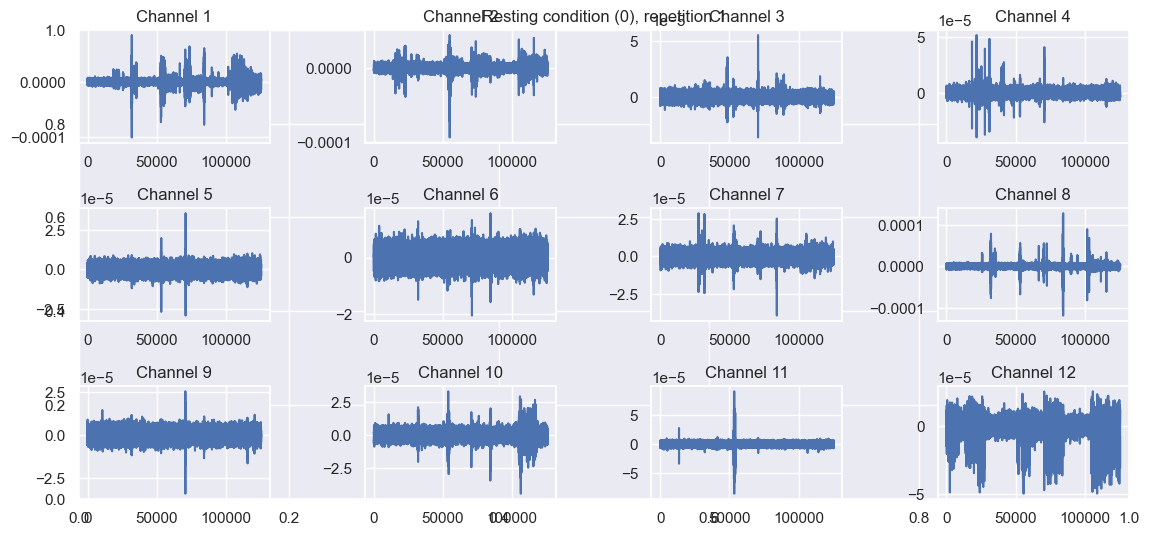

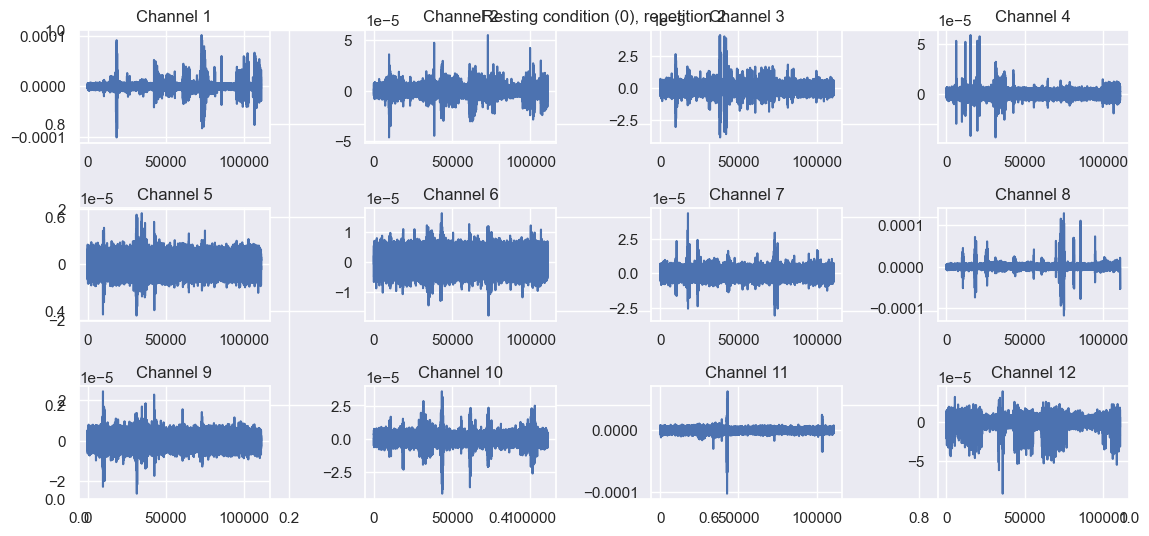

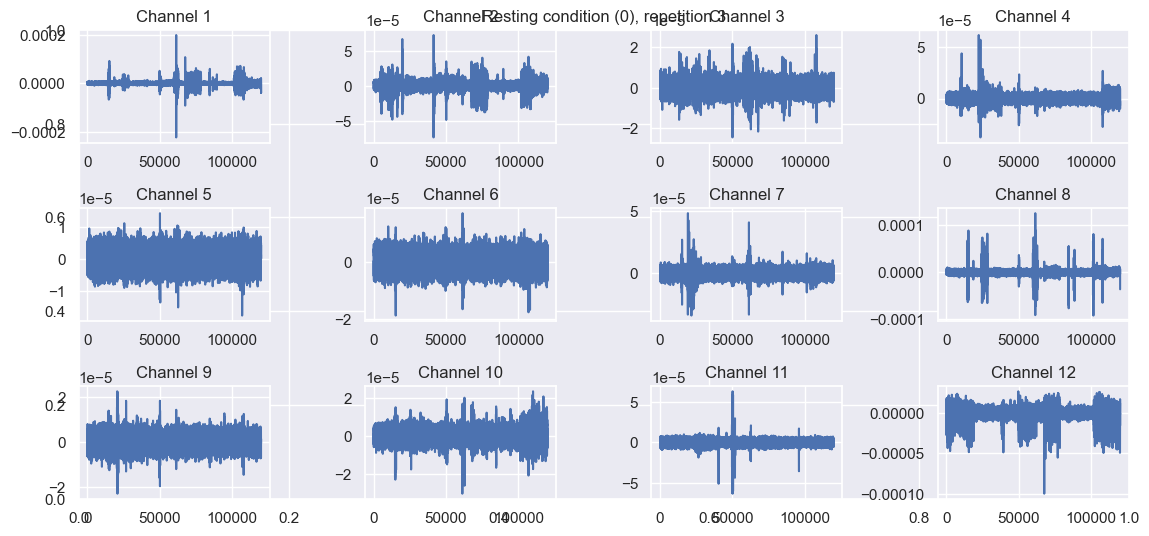

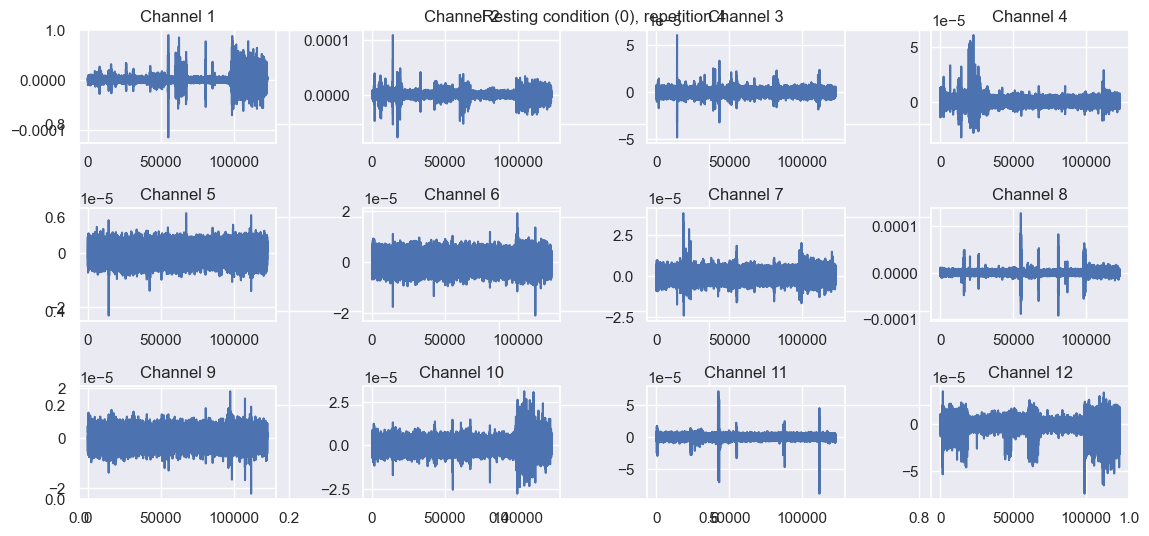

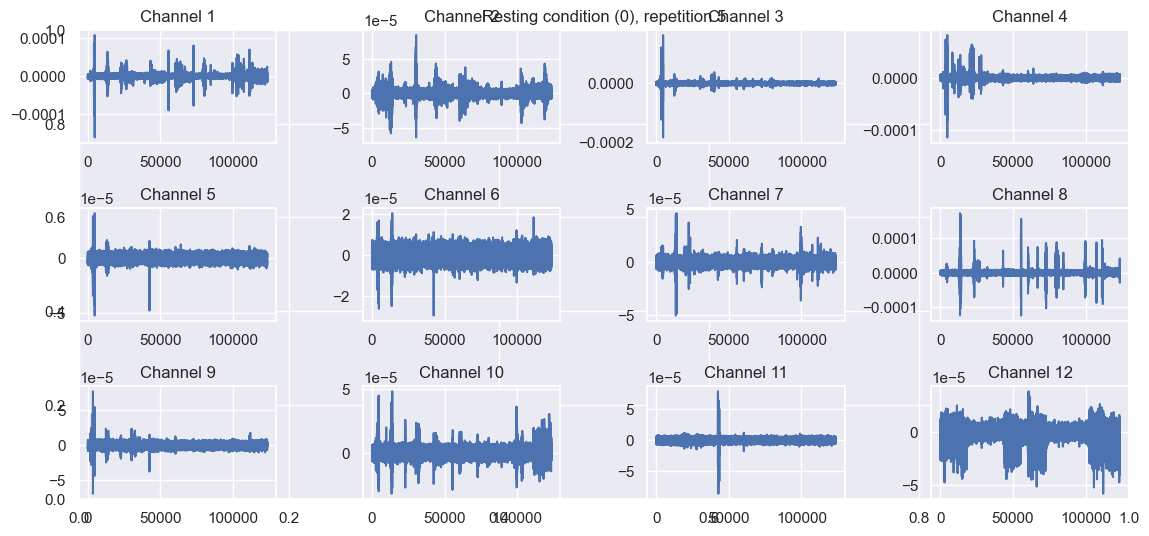

In [9]:
# Channel 1-8 : equally spaced electrodes on the forearm
# Channel 9-10 : Flexor Digitorum Superficialis and Extensor Digitorum Superficialis muscles
# Channel 11-12 : Biceps Brachii and Triceps Brachii muscles

# Plot signal for rest (0)
for rep in range(n_repetitions):
    plt.figure(figsize=(12, 6))
    plt.title(f"Resting condition (0), repetition {rep+1}")
    for channel_idx in range(n_channels): 
        plt.subplot(3, 4, channel_idx+1)
        plt.plot(emg_windows[0][rep][:, channel_idx])
        plt.title(f"Channel {channel_idx+1}")
    plt.tight_layout()
    plt.show()

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

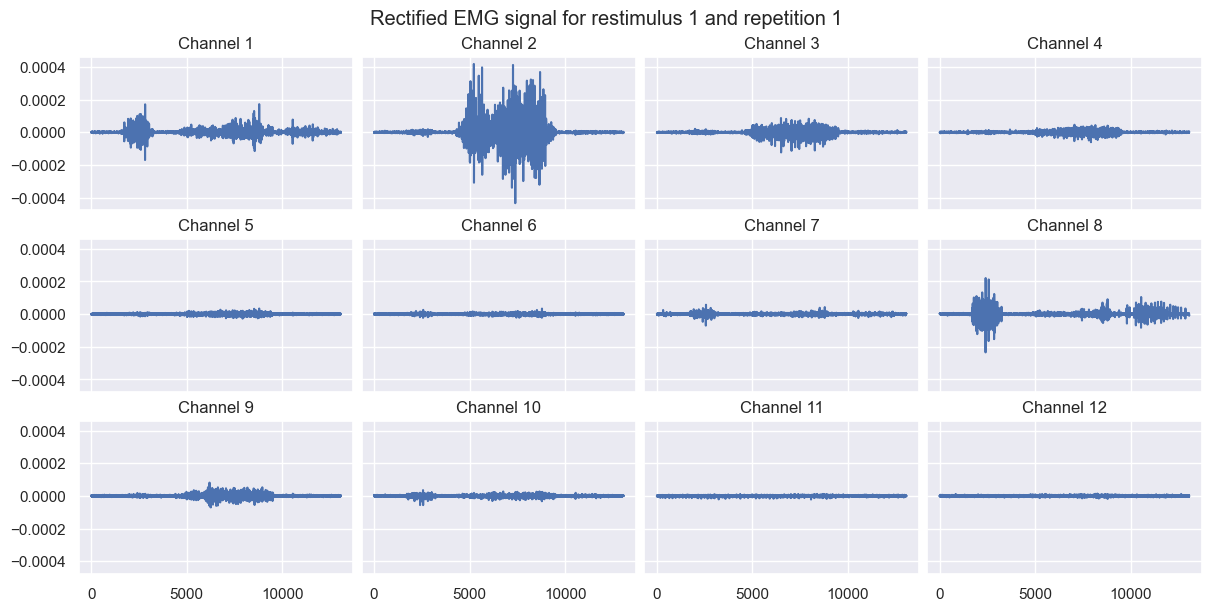

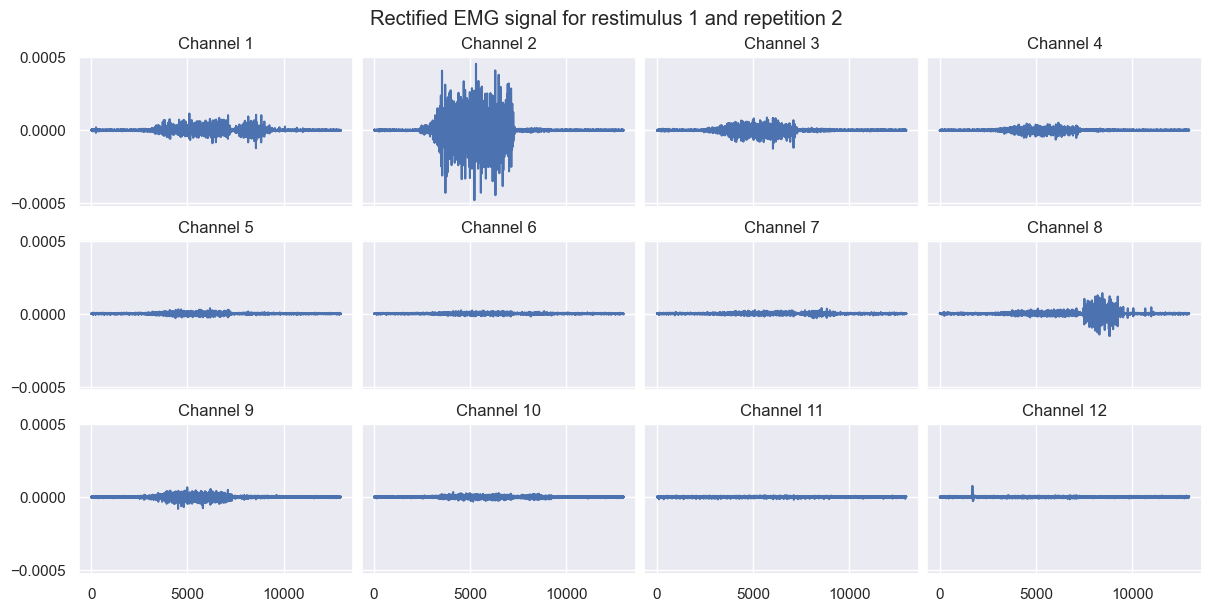

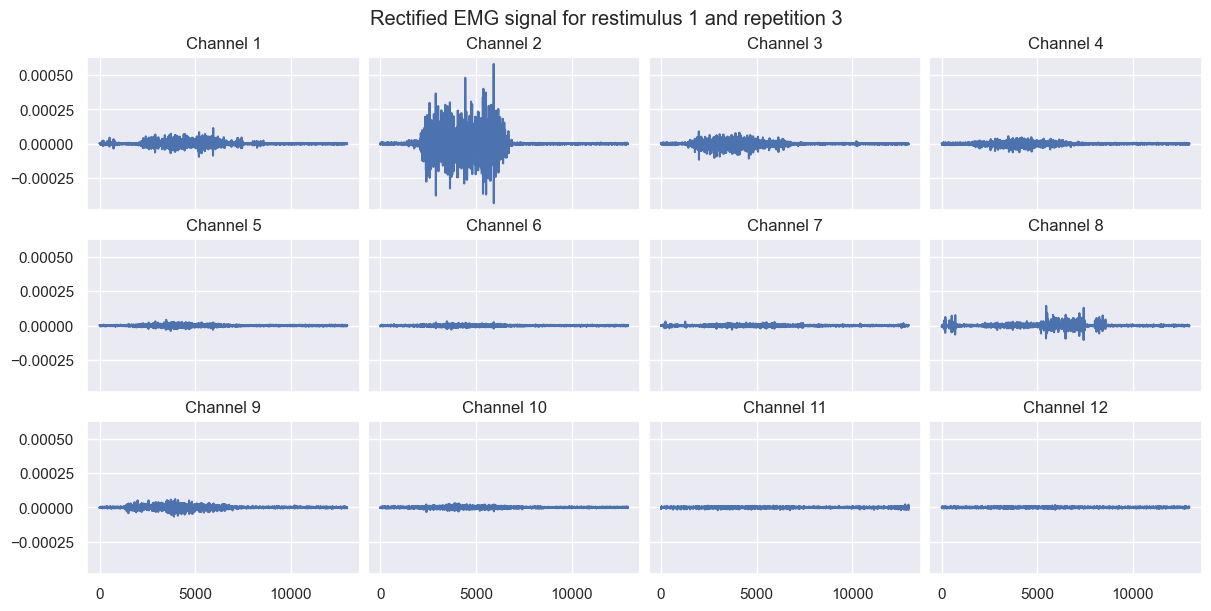

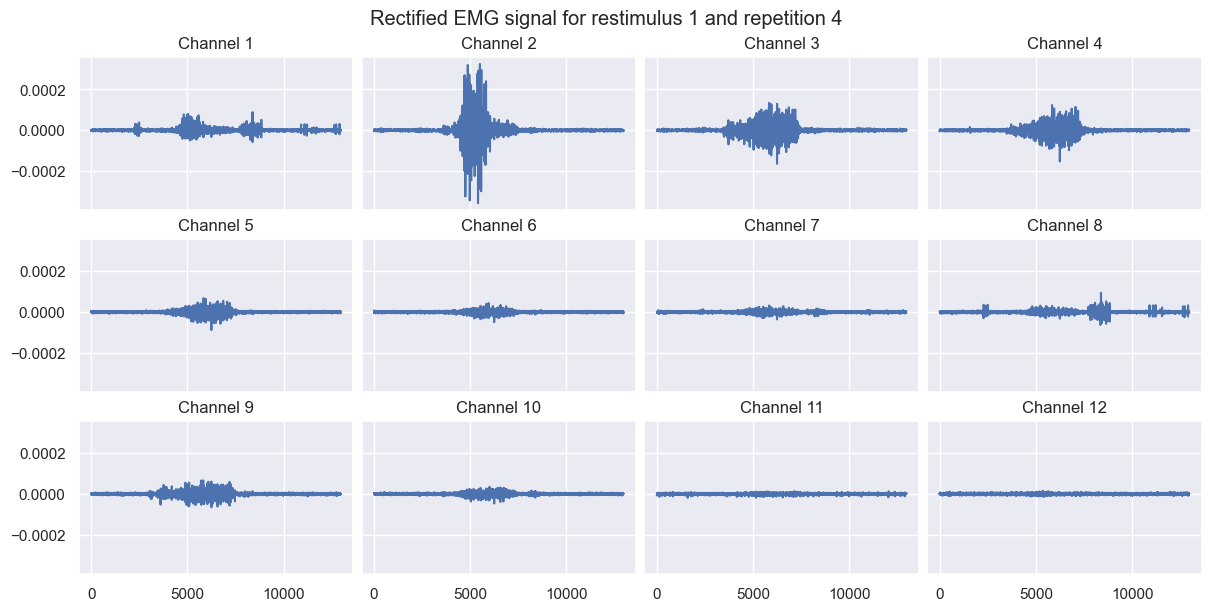

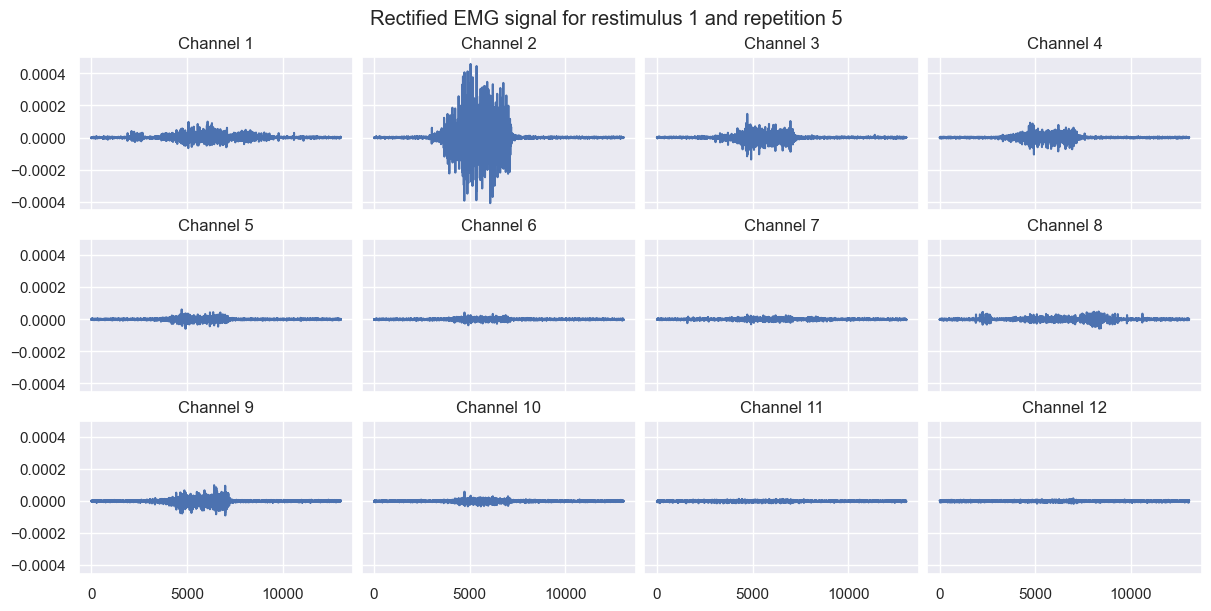

In [10]:
# Plot signal for fist action (6)


for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[6][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")


# # Envelopes
# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_envelopes[6][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

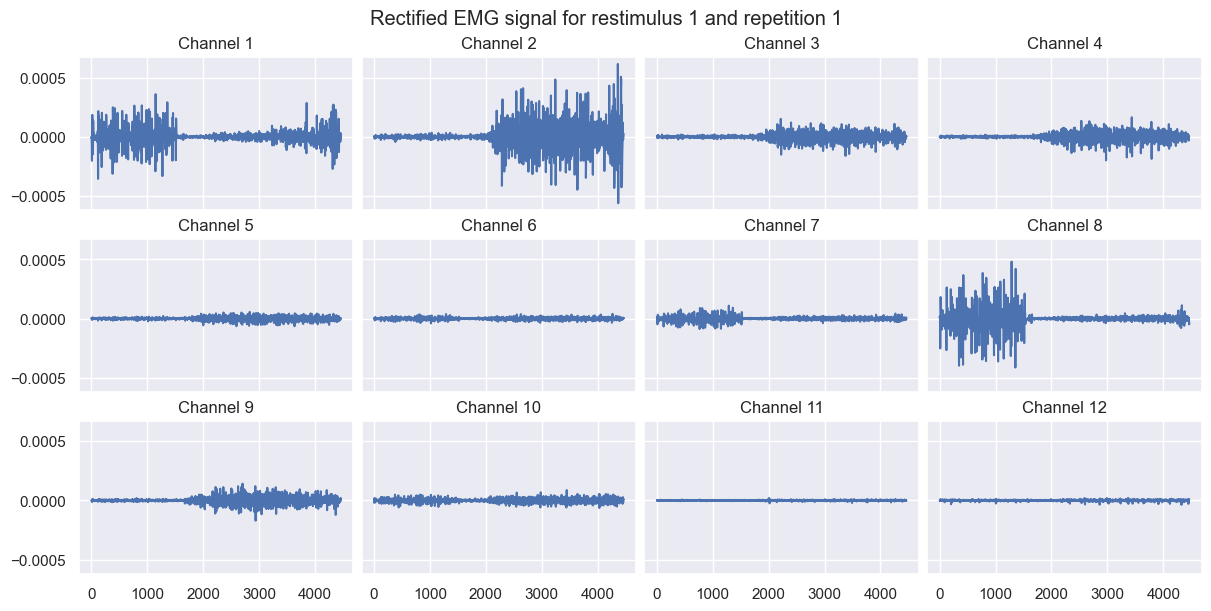

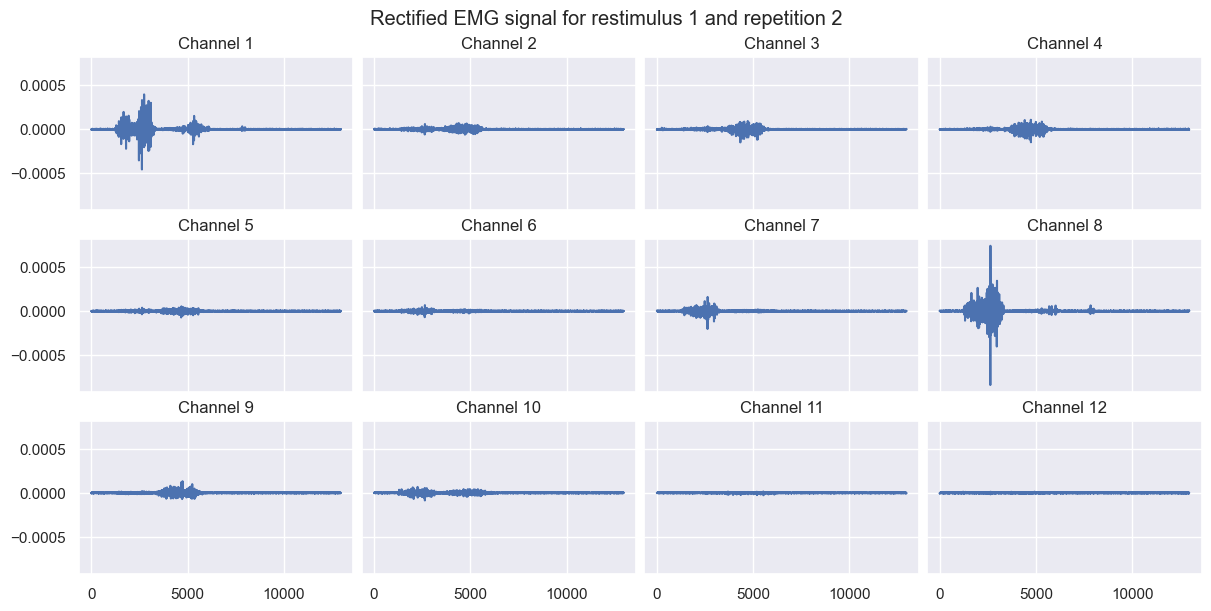

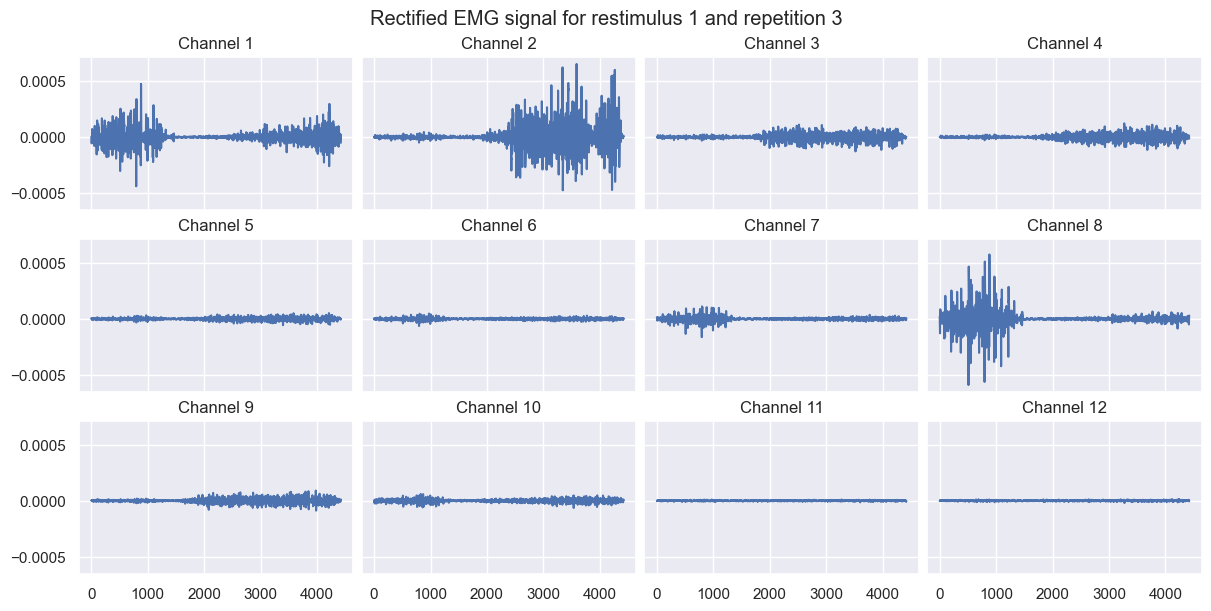

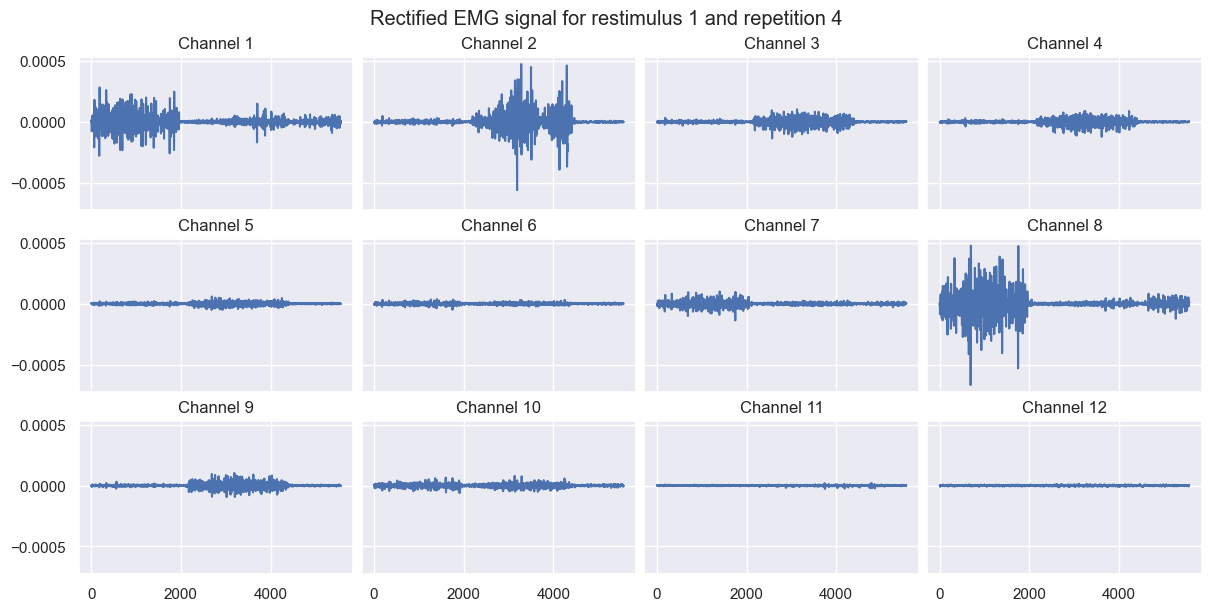

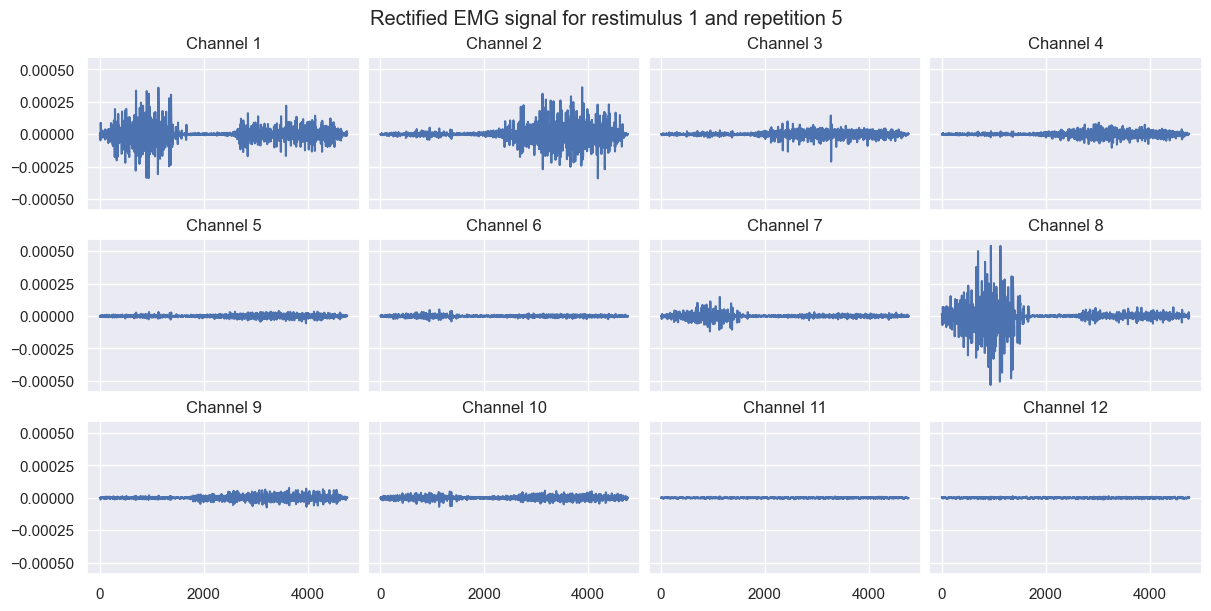

In [11]:
# Plot signal for wrist flexion action (13)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[13][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[13][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

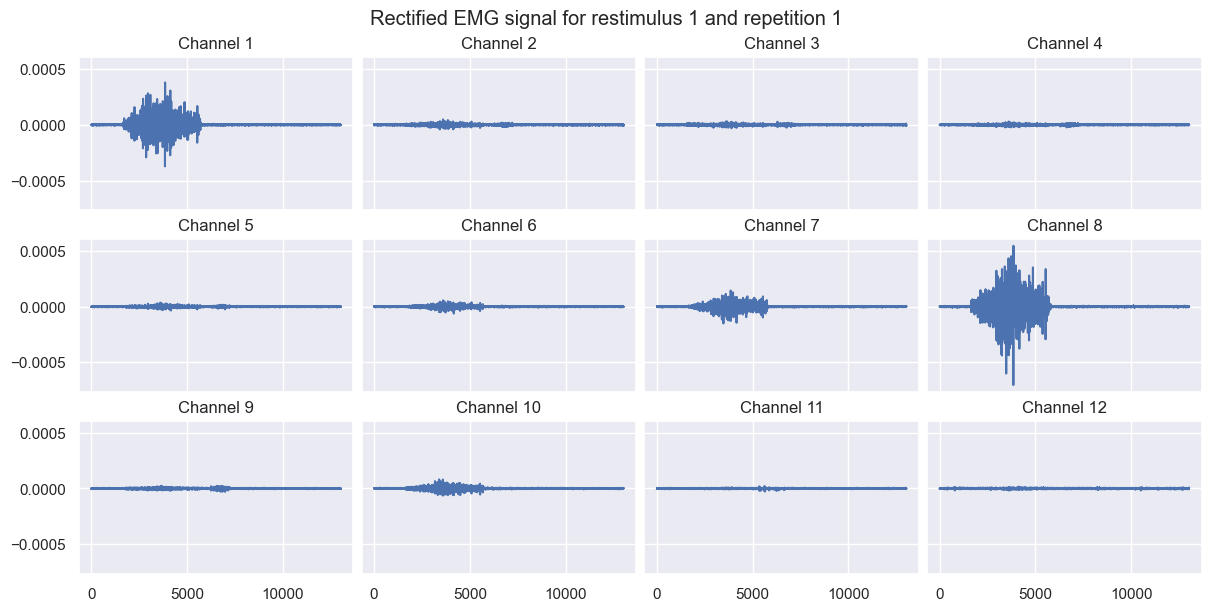

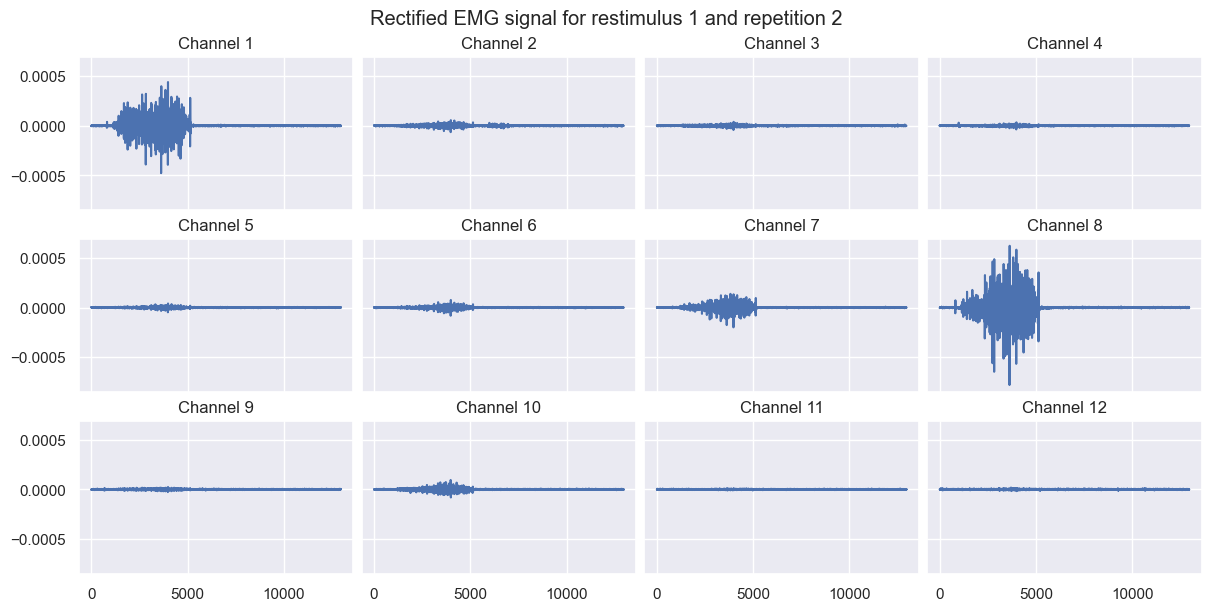

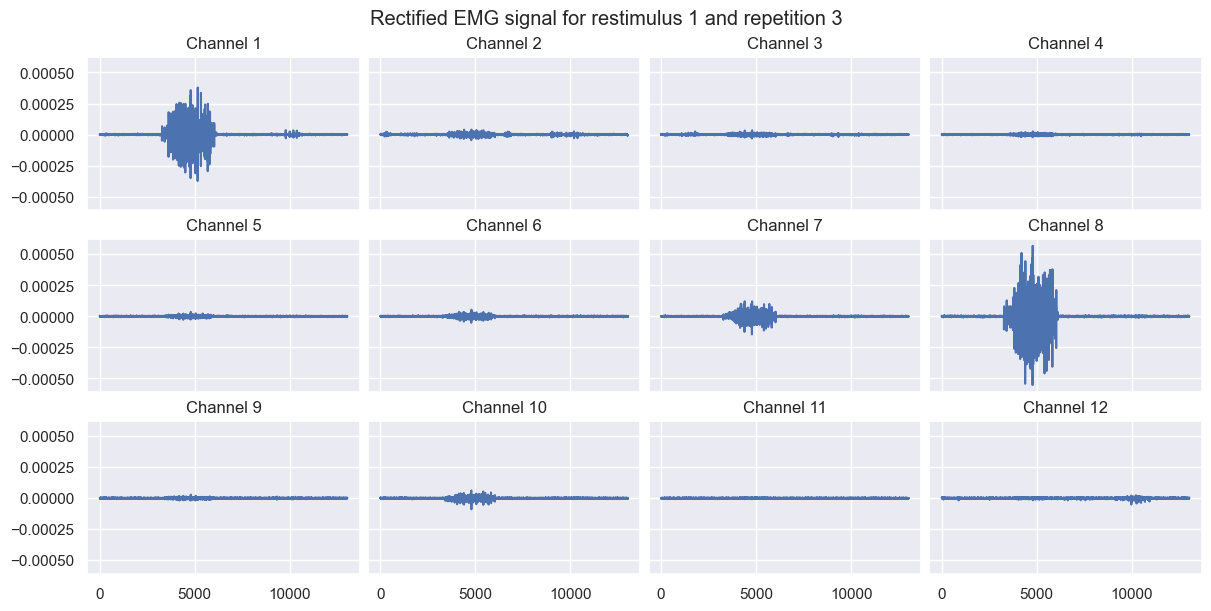

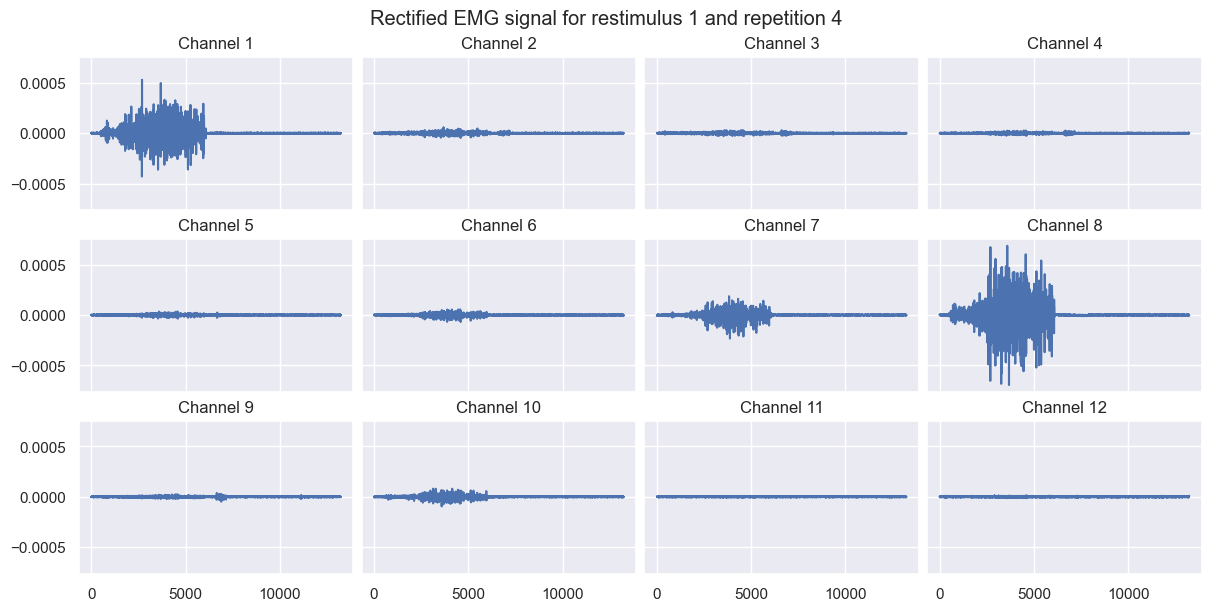

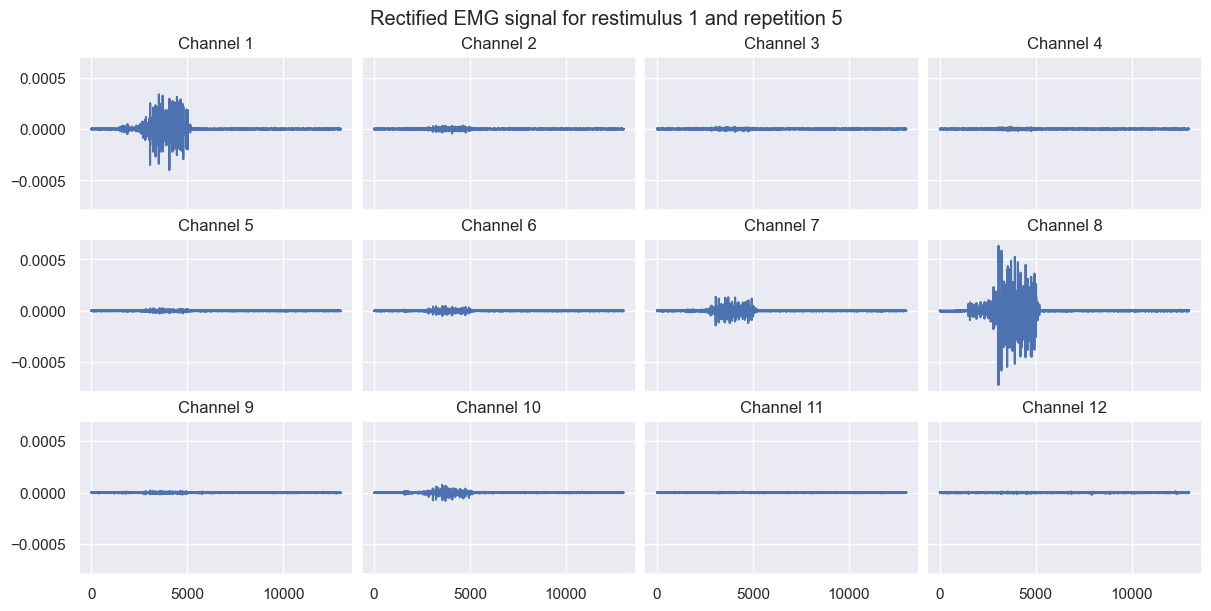

In [12]:
# Plot signal for wrist extension action (14)
for rep in range(n_repetitions):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    #10 EMG channels
    number_of_emg_channels = emg_rectified.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[14][rep][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle(f"Rectified EMG signal for restimulus 1 and repetition {rep+1}")

# fig, ax = plt.subplots(3, 4, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# #10 EMG channels
# number_of_emg_channels = emg_rectified.shape[-1]
# # plot Rectified EMG signal
# for channel_idx in range(number_of_emg_channels): 
#     ax[channel_idx].plot(emg_windows[14][0][:, channel_idx])
#     ax[channel_idx].set_title(f"Channel {channel_idx+1}")
# plt.suptitle("Rectified EMG signal for restimulus 1")

In [13]:
# emg_average_activations = np.zeros((n_channels, n_stimuli+1, n_repetitions))
# for stimuli_idx in range(n_stimuli+1):
#     for repetition_idx in range(n_repetitions):
#         #mean across time for each channel
#         emg_average_activations[:, stimuli_idx, repetition_idx] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0) 

# vmin = np.min(emg_average_activations) 
# vmax = np.max(emg_average_activations)

# fig, ax = plt.subplots(9, 2, figsize=(10, 30), constrained_layout=True, sharex=True, sharey=True)
# ax = ax.ravel()

# for stimuli_idx in range(n_stimuli+1):
#     sns.heatmap(np.squeeze(emg_average_activations[:, stimuli_idx, :]), ax=ax[stimuli_idx] ,xticklabels=False, yticklabels=False, cbar=True, vmin=vmin, vmax=vmax,)
#     ax[stimuli_idx].title.set_text("Restimulus " + str(stimuli_idx))
#     ax[stimuli_idx].set_xlabel("Rerepetition")
#     ax[stimuli_idx].set_ylabel("EMG channel")

## Personal data

In [14]:
data_pers = pd.read_csv("data/pers_data/cleaned/cleaned_WS_R_4_250328161002.csv")
print(f"Data shape: {data_pers.shape}")
print(f"Data columns: {data_pers.columns}")

Data shape: (71989, 5)
Data columns: Index(['Timestamp', 'Channel1', 'Channel2', 'Action1', 'Action2'], dtype='object')


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

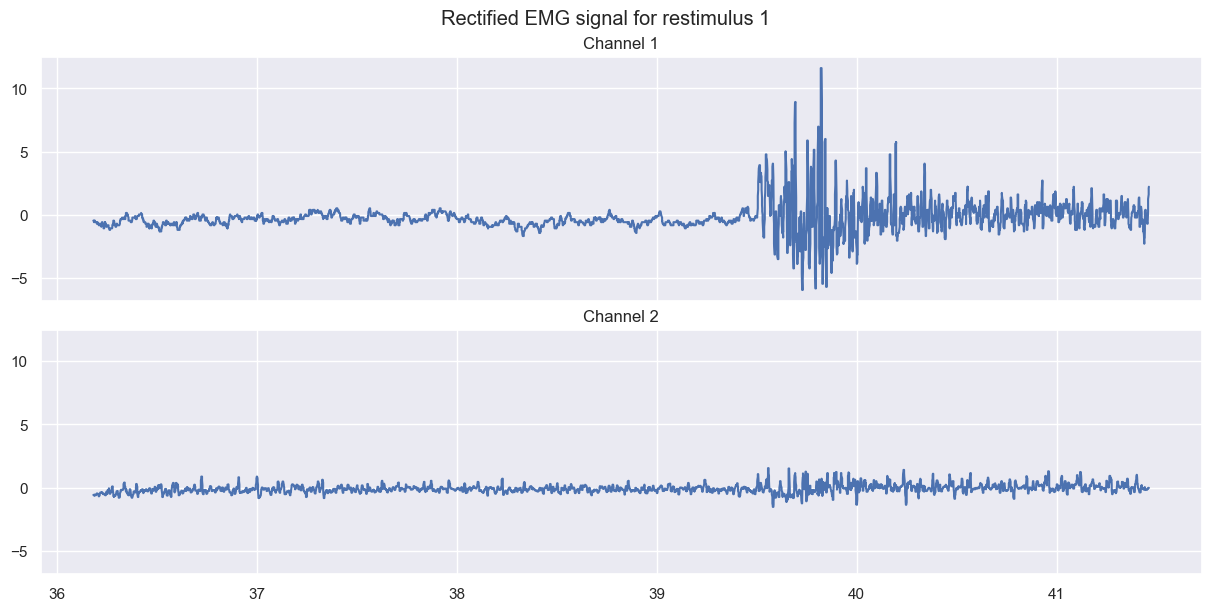

In [15]:
# Look for the first window of fist action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "Fist")].index[0]
end_id = data_pers[(data_pers["Action1"] == "Fist") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

# plt.figure(figsize=(12, 4))
# plt.plot(window_df['Timestamp'], window_df['Channel1'], label='Channel1')
# plt.plot(window_df['Timestamp'], window_df['Channel2'], label='Channel2')
# plt.title("First 'Fist' Action Window")
# plt.xlabel("Time (s)")
# plt.ylabel("Signal")
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

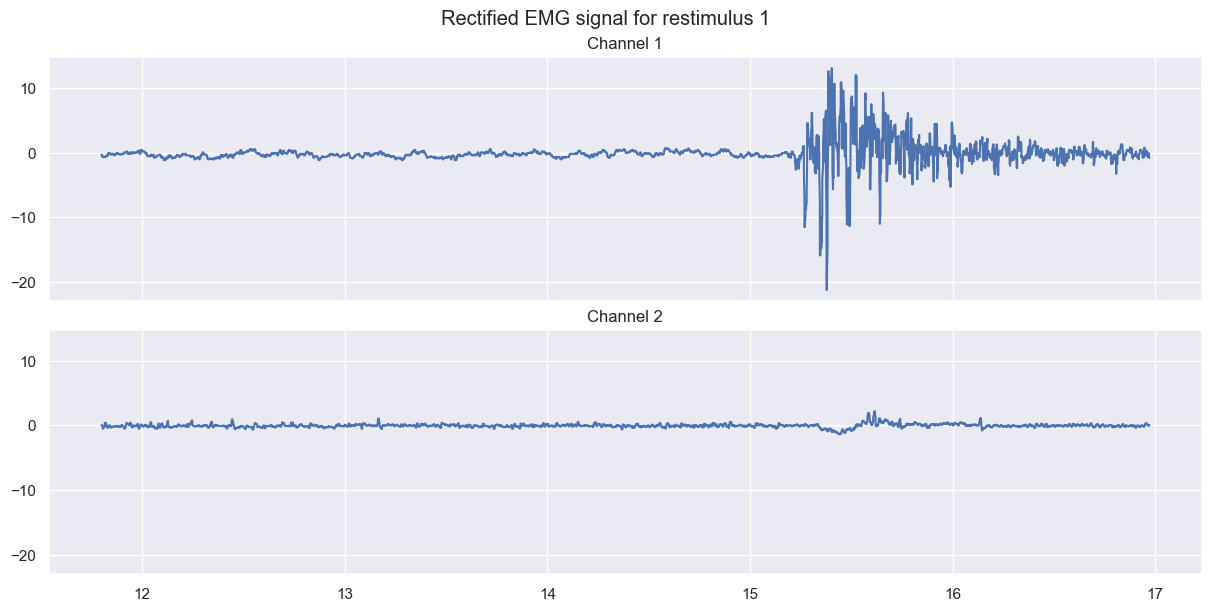

In [16]:
# Same for wrist flexion action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristFlexion")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristFlexion") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")


Text(0.5, 0.98, 'Rectified EMG signal for restimulus 1')

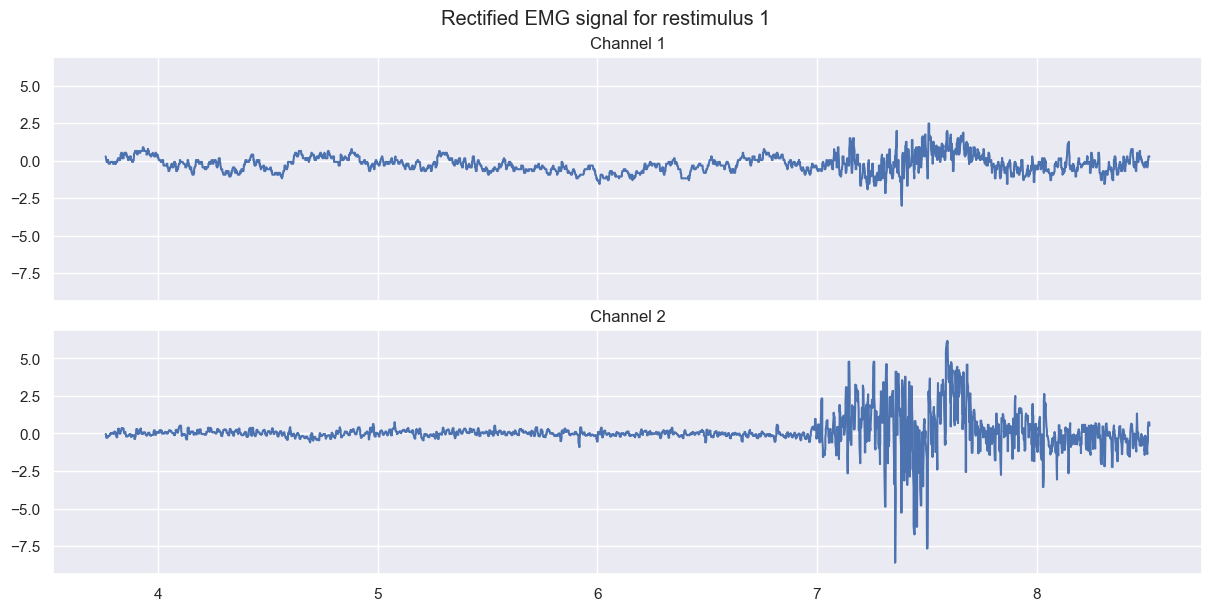

In [17]:
# Same for wrist extension action
start_id = data_pers[(data_pers["Action1"] == "Rest") & (data_pers["Action2"] == "WristExt")].index[0]
end_id = data_pers[(data_pers["Action1"] == "WristExt") & (data_pers["Action2"] == "Rest")].index[-1]
window_df = data_pers.loc[start_id:end_id]

fig, ax = plt.subplots(2, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

#2 EMG channels
for channel_idx in range(2): 
    ax[channel_idx].plot(window_df['Timestamp'], window_df['Channel{}'.format(channel_idx+1)])
    ax[channel_idx].set_title(f"Channel {channel_idx+1}")
plt.suptitle("Rectified EMG signal for restimulus 1")

# Correlation of channels between dataset

In [18]:
def compute_flat_label(row):
    if row['Action1'] == 'Rest' and pd.isna(row['Action2']): # return 'Rest' if Action1 is 'Rest' and Action2 is NaN
        return 'Rest'
    elif row['Action1'] != 'Rest' and pd.isna(row['Action2']): # if Action2 is NaN, return Action1 (except for 'Rest')
        return row['Action1']
    else:
        return row['Action2']  # transition phase, but will be merged into gesture


In [19]:
# Create single label for each row
data_pers_copy = data_pers.copy()
data_pers_copy.drop(index=0, inplace=True)
data_pers_copy['Gesture'] = data_pers_copy.apply(compute_flat_label, axis=1)
data_pers_copy.drop(columns=['Action1', 'Action2'], inplace=True)

In [20]:
data_pers_copy.head()

,Timestamp,Channel1,Channel2,Gesture
1,0.161,-0.565049,-0.815220,Rest
2,0.161,-0.565049,-0.870914,Rest
3,0.162,-0.565049,-0.926608,Rest
4,0.162,-0.443307,-1.010148,Rest
5,0.162,-0.565049,-1.037995,Rest


## Resample Ninapro and personnal data at 1000Hz

In [21]:


def downsample_dataframe_with_labels(df, target_freq, time_col='Timestamp', label_cols=None, method='resample'):
    """
    Downsamples a DataFrame with timestamp, signal columns, and optional label columns.
    
    Parameters:
        df : pd.DataFrame
            Input data (must include a time column).
        target_freq : int
            Target sampling frequency in Hz.
        time_col : str
            Name of the time column.
        label_cols : list of str
            Columns with categorical labels (e.g., ['FlatLabel', 'Action1', 'Action2']).
        method : str
            'resample' (FFT-based) or 'average' (bin-average + mode for labels).
    
    Returns:
        pd.DataFrame
            Downsampled DataFrame with aligned time, signal, and label columns.
    """
    if time_col not in df.columns:
        raise ValueError(f"{time_col} must be in dataframe")

    label_cols = label_cols or []
    all_cols = df.columns.tolist()
    signal_cols = [col for col in all_cols if col not in [time_col] + label_cols]

    t_orig = df[time_col].values
    t_start, t_end = t_orig[0], t_orig[-1]
    duration = t_end - t_start
    n_target = int(duration * target_freq)

    # Downsample signals
    if method == 'resample':
        signals_ds = pd.DataFrame(
            resample(df[signal_cols].values, n_target),
            columns=signal_cols
        )
    elif method == 'average':
        df_indexed = df.set_index(time_col)
        df_indexed.index = pd.to_datetime(df_indexed.index, unit='s')
        signals_ds = df_indexed[signal_cols].resample(f"{int(1000/target_freq)}ms").mean().dropna().reset_index(drop=True)
    else:
        raise ValueError("method must be 'resample' or 'average'")

    # Generate new time vector
    t_uniform = np.linspace(t_start, t_end, n_target, endpoint=False)
    signals_ds.insert(0, time_col, t_uniform)

    # Downsample labels using mode per time bin
    if label_cols:
        df_label = df[[time_col] + label_cols].copy()
        df_label.index = pd.to_datetime(df_label[time_col], unit='s')

        bin_size_ms = int(1000 / target_freq)
        label_resampled = []

        for col in label_cols:
            grouped = df_label[col].resample(f"{bin_size_ms}ms").agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
            label_resampled.append(grouped)

        label_df = pd.concat(label_resampled, axis=1)
        label_df.columns = label_cols
        label_df = label_df.dropna().reset_index(drop=True)

        # Align label_df to signal df
        label_df = label_df.iloc[:len(signals_ds)]
        signals_ds[label_cols] = label_df

    return signals_ds


In [22]:
downsampled_data_pers = downsample_dataframe_with_labels(data_pers_copy, target_freq=1000, time_col='Timestamp', label_cols=['Gesture'], method='resample')
downsampled_data_pers.head()

,Timestamp,Channel1,Channel2,Gesture
0,0.161,-0.504602,-0.670395,Rest
1,0.162,-0.586215,-0.944057,Rest
2,0.163,-0.473983,-0.969143,Rest
3,0.164,-0.563936,-1.079206,Rest
4,0.165,-0.572229,-1.144015,Rest


In [23]:
np.shape(data_DB3_s1_E1['emg'])

(1825008, 12)

In [24]:
# Create an empty DataFrame to store the data
data_ninapro = pd.DataFrame()

for channel in range(n_channels):
    data_ninapro[f'Channel{channel+1}'] = emg_rectified[:, channel].flatten()
data_ninapro['Stimulus'] = stimulus.flatten()
data_ninapro['Repetition'] = repetition.flatten()
data_ninapro['Restimulus'] = restimulus.flatten()
data_ninapro['Rerepetition'] = rerepetition.flatten()

sampling_rate = 2000  # Hz (samples per second)
n_samples = data_ninapro.shape[0]
data_ninapro['Timestamp'] = np.arange(n_samples) / sampling_rate  # Create a timestamp column


In [25]:
data_ninapro.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


##### Downsample then read

In [28]:
if False:
    data_ninapro_copy = data_ninapro.copy()
    downsampled_data_ninapro = downsample_dataframe_with_labels(data_ninapro_copy, target_freq=1000, time_col='Timestamp', label_cols=['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'], method='resample')
    downsampled_data_ninapro.head()
    downsampled_data_ninapro.to_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv", index=False)

In [29]:
downsampled_data_ninapro = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
downsampled_data_ninapro.head()

,Timestamp,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition
0,0.000,0.000004,3.421130e-07,-0.000004,-7.395218e-07,-1.648205e-07,-0.000001,-2.462329e-06,-0.000003,2.178590e-06,-0.000005,9.750480e-07,8.729874e-07,0,0,0,1
1,0.001,0.000004,-4.112867e-06,-0.000004,8.034041e-07,-1.258258e-06,-0.000002,7.390273e-07,-0.000005,2.081342e-06,-0.000005,1.550235e-06,2.855237e-06,0,0,0,1
2,0.002,0.000003,-8.064127e-07,-0.000003,-2.994702e-07,-3.919208e-06,-0.000004,4.794938e-07,-0.000003,-2.425310e-06,-0.000003,6.500644e-07,7.891234e-07,0,0,0,1
3,0.003,0.000004,2.282617e-06,-0.000003,-1.401341e-07,-4.994414e-07,-0.000003,5.482524e-07,-0.000004,5.588637e-08,-0.000001,-8.470170e-07,4.445305e-06,0,0,0,1
4,0.004,0.000004,2.605559e-06,-0.000005,-7.612063e-07,-2.968801e-06,-0.000004,3.764431e-06,-0.000006,6.121387e-06,-0.000001,7.550654e-07,5.035874e-06,0,0,0,1


length of stimulus 1 for repetition 1,2,3,4: 6031 5433 5530 5561
length of restimulus 1 for repetition 1,2,3,4: 7013 6404 6512 6522


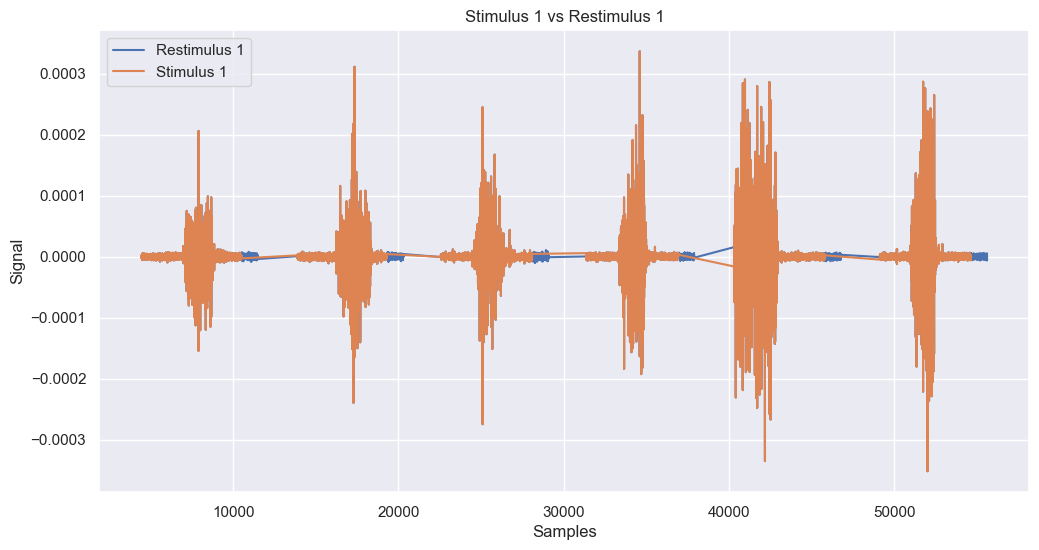

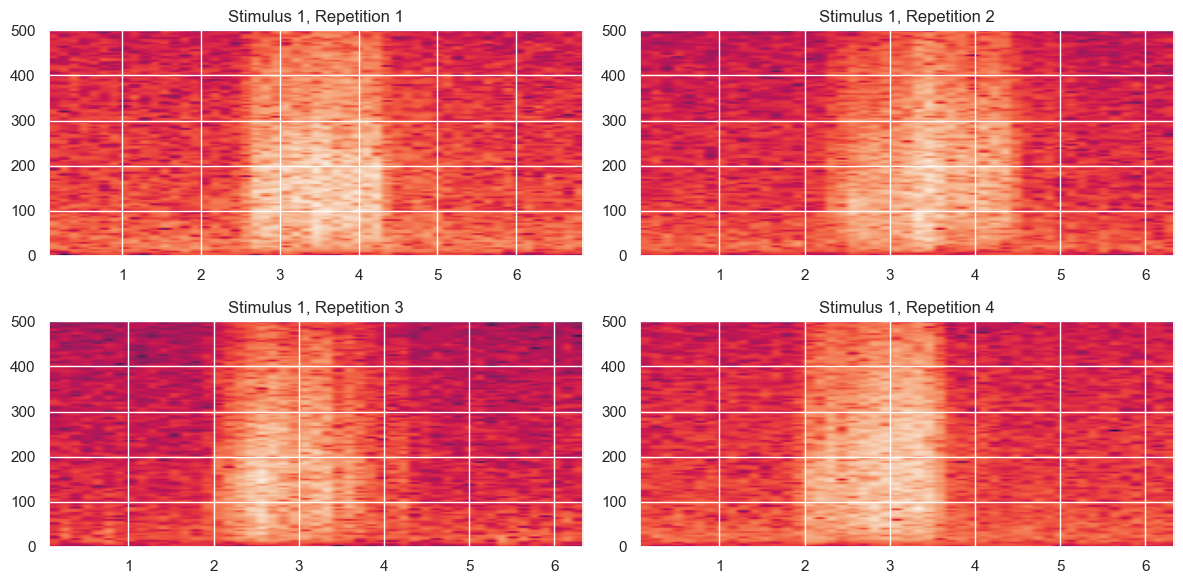

In [31]:
downsampled_data_ninapro.Stimulus.unique()
downsampled_data_ninapro.Restimulus.unique()

stim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Stimulus'] == 1]["Channel1"]
restim_1 = downsampled_data_ninapro[downsampled_data_ninapro['Restimulus'] == 1]["Channel1"]
rep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Repetition'] == 1]["Channel1"]
rerep_1 = downsampled_data_ninapro[downsampled_data_ninapro['Rerepetition'] == 1]["Channel1"]


# plot stim_1 and restim_1
plt.figure(figsize=(12, 6))
plt.plot(restim_1, label='Restimulus 1')
plt.plot(stim_1, label='Stimulus 1')
# plt.plot(rep_1, label='Repetition 1')
# plt.plot(rerep_1, label='Rerepetition 1')
plt.title("Stimulus 1 vs Restimulus 1")
plt.xlabel("Samples")
plt.ylabel("Signal")
plt.legend()


stim_1_r1 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 1")["Channel1"]
stim_1_r2 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 2")["Channel1"]
stim_1_r3 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 3")["Channel1"]
stim_1_r4 = downsampled_data_ninapro.query("Stimulus == 1 and Repetition == 4")["Channel1"]

print("length of stimulus 1 for repetition 1,2,3,4:", len(stim_1_r1), len(stim_1_r2), len(stim_1_r3), len(stim_1_r4))

restim_1_r1 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 1")["Channel1"]
restim_1_r2 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 2")["Channel1"]
restim_1_r3 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 3")["Channel1"]
restim_1_r4 = downsampled_data_ninapro.query("Restimulus == 1 and Rerepetition == 4")["Channel1"]

print("length of restimulus 1 for repetition 1,2,3,4:",len(restim_1_r1), len(restim_1_r2), len(restim_1_r3), len(restim_1_r4))


# plot the spectrogram of the stimulus 1 for repetition 1,2,3,4
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.specgram(restim_1_r1, Fs=1000, NFFT=256, noverlap=128)
plt.title("Stimulus 1, Repetition 1")
plt.subplot(2, 2, 2)
plt.specgram(restim_1_r2, Fs=1000, NFFT=256, noverlap=128)
plt.title("Stimulus 1, Repetition 2")
plt.subplot(2, 2, 3)
plt.specgram(restim_1_r3, Fs=1000, NFFT=256, noverlap=128)
plt.title("Stimulus 1, Repetition 3")
plt.subplot(2, 2, 4)
plt.specgram(restim_1_r4, Fs=1000, NFFT=256, noverlap=128)
plt.title("Stimulus 1, Repetition 4")
plt.tight_layout()
plt.show()


## Correlation between channels

In [33]:
# Map personnal labels to Ninapro labels

movement_ExA = {
    0: "Rest",
    1: "IndexFlex",
    3: "MiddleFlex",
    5: "RingPinkyFlex",
    7: "RingPinkyFlex",
    9: "ThumbAdd",
    10: "ThumbAbd",
    11: "ThumbFlex",
}

movement_ExB = {
    0: "Rest",
    1: "ThumbUp",
    2: "Scisors",
    5: "Palm",
    6: "Fist",
    9: "WristRotIn",
    10: "WristRotExt",
    13: "WristFlexion",
    14: "WristExt",
}

movement_ExC = {
    0: "Rest",
    1: "CylindGraspClosed",
    2: "CylindGraspClosed",
    3: "HookGraspClosed",
    14: "PinchGraspClosed",
    15: "PinchGraspClosed",
    19: "LumbGraspClosed",
}

pers_gestures = {"Rest", "Fist", "WristFlexion", "WristExt", "WristRotIn", "WristRotExt", "Palm"}

gesture_to_id = {v: k for k, v in movement_ExB.items() if v in pers_gestures}
gesture_to_id

{'Rest': 0,
 'Palm': 5,
 'Fist': 6,
 'WristRotIn': 9,
 'WristRotExt': 10,
 'WristFlexion': 13,
 'WristExt': 14}

### Possible Onset detection using total power of all channels?

Action1:  [ 0 14 13  9 10  6  5]
Action2:  [-1 14  0 13  9 10  6  5]


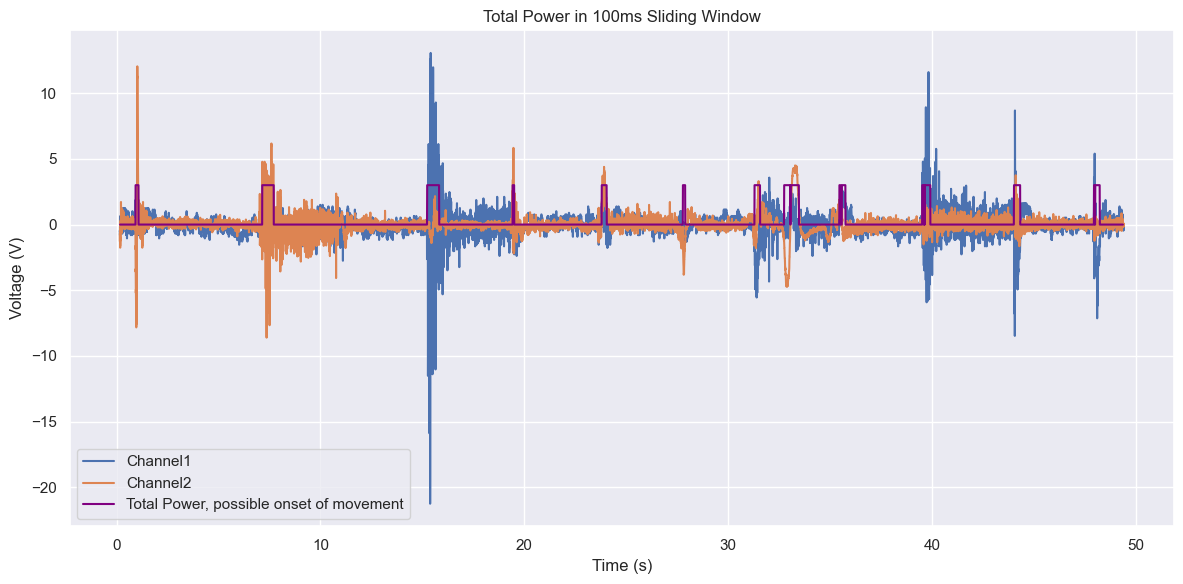

In [86]:
sample_of_personal_dataset = pd.read_csv("data/pers_data/cleaned/cleaned_WS_R_4_250328161002.csv")
sample_of_personal_dataset
plt.figure(figsize=(12, 6))
plt.plot(sample_of_personal_dataset['Timestamp'], sample_of_personal_dataset['Channel1'], label='Channel1')
plt.plot(sample_of_personal_dataset['Timestamp'], sample_of_personal_dataset['Channel2'], label='Channel2')

# convert the Action1 and action2 columns to numbers, and -1 if it is Nan
sample_of_personal_dataset['Action1'] = sample_of_personal_dataset['Action1'].map(gesture_to_id).fillna(-1).astype(int)
sample_of_personal_dataset['Action2'] = sample_of_personal_dataset['Action2'].map(gesture_to_id).fillna(-1).astype(int)
sample_of_personal_dataset['Action1'] = sample_of_personal_dataset['Action1'].astype(int)
sample_of_personal_dataset['Action2'] = sample_of_personal_dataset['Action2'].astype(int)
# print what each number means
print("Action1: ", sample_of_personal_dataset['Action1'].unique())
print("Action2: ", sample_of_personal_dataset['Action2'].unique())

# plot action1 and action 2 over the signal
# plt.figure(figsize=(12, 6))
# plt.plot(sample_of_personal_dataset['Timestamp'], sample_of_personal_dataset['Action1'], label='Action1')
# plt.plot(sample_of_personal_dataset['Timestamp'], sample_of_personal_dataset['Action2'], label='Action2')

# next, plot the amplitude of the total power of the signal in a certain time window
import numpy as np
import matplotlib.pyplot as plt

# Parameters
window_size_sec = 0.1 # 200 ms window
step_size_sec = 0.01    # 10 ms step
fs = 1000               # Sampling frequency ~1500Hz

window_size = int(window_size_sec * fs)
step_size = int(step_size_sec * fs)

# Signals
signal1 = sample_of_personal_dataset['Channel1'].values
signal2 = sample_of_personal_dataset['Channel2'].values
timestamps = sample_of_personal_dataset['Timestamp'].values

# Prepare sliding window total power calculation
total_power1 = []
time_axis = []
total_power2 = []

now = time.time()
for start in range(0, len(signal2) - window_size, step_size):
    
    end = start + window_size
    segment2 = signal2[start:end]
    segment1 = signal1[start:end]

    fft_vals2 = np.abs(np.fft.rfft(segment2))**2
    fft_vals1 = np.abs(np.fft.rfft(segment1))**2

    # fft_vals1 = fft_vals1/np.mean(segment1**2)
    # fft_vals2 = fft_vals2/np.mean(segment2**2)
    power2 = np.sum(fft_vals2)
    power1 = np.sum(fft_vals1)


    total_power2.append(power2)
    total_power1.append(power1)

    time_axis.append(timestamps[start + window_size // 2])  # Center of window

total_power1 = np.array(total_power1)
total_power2 = np.array(total_power2)
# Plot Total Power over time
# plt.figure(figsize=(12, 6))
# plt.plot(time_axis, total_power1, color='purple')
# plt.plot(time_axis, total_power2, color='green')
total_power = total_power1 + total_power2


plt.plot(time_axis, (total_power>25000)*3, color='purple', label='Total Power, possible onset of movement')
plt.title(f'Total Power in {window_size_sec*1000:.0f}ms Sliding Window')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')

plt.tight_layout()
plt.legend()
plt.show()




In [29]:
# Channel 1 pers data -> Channel 2 ninapro
# Channel 2 pers data -> Channel 8 ninapro

# --> train classifier on Ninapro data (2 & 8) and test on personal data (1 & 2)

## Model

In [30]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    print(f"Number of samples: {n_samples}, Number of features: {n_features}, Number of channels: {n_channels}")
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0

            # Select the time steps corresponding to the current stimulus and repetition
            
            selected_tsteps = np.logical_and(stimulus == stimulus.unique()[i], repetition == repetition.unique()[j]).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result

                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

In [40]:
# Define the features 

# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

#Feel free to add more features, e.g. frequency domain features. (See https://doi.org/10.3390/s19204596 and https://doi.org/10.1088/0967-3334/24/2/307)

# Mean Frequency (MNF)
mnf = lambda x, fs: np.sum(
    np.fft.rfftfreq(x.shape[0], 1/fs)[:, None] * np.abs(np.fft.rfft(x, axis=0)),
    axis=0
) / np.sum(np.abs(np.fft.rfft(x, axis=0)), axis=0)

# Median Frequency (MDF)
mdf = lambda x, fs: np.array([
    np.fft.rfftfreq(x.shape[0], 1/fs)[
        np.where(np.cumsum(np.abs(np.fft.rfft(x[:, ch]))) >= np.sum(np.abs(np.fft.rfft(x[:, ch]))) / 2)[0][0]
    ] for ch in range(x.shape[1])
])

# Peak Frequency (PKF)
pkf = lambda x, fs: np.array([
    np.fft.rfftfreq(x.shape[0], 1/fs)[np.argmax(np.abs(np.fft.rfft(x[:, ch])))]
    for ch in range(x.shape[1])
])

# Total Power (TP)
tp = lambda x: np.sum(np.abs(np.fft.rfft(x, axis=0))**2, axis=0)

# Frequency Ratio (FR) — split at 100Hz
fr = lambda x, fs, split_freq=100: np.array([
    (lambda freqs, psd: np.sum(psd[freqs <= split_freq]) / np.sum(psd[freqs > split_freq]) 
     if np.sum(psd[freqs > split_freq]) != 0 else 0)(
        np.fft.rfftfreq(x.shape[0], 1/fs), 
        np.abs(np.fft.rfft(x[:, ch]))**2
    ) for ch in range(x.shape[1])
])

# Spectral Entropy (SpecEnt)
specent = lambda x: np.array([
    (lambda psd: -np.sum(psd * np.log2(psd + 1e-12)))(
        np.abs(np.fft.rfft(x[:, ch]))**2 / np.sum(np.abs(np.fft.rfft(x[:, ch]))**2)
    ) for ch in range(x.shape[1])
])


# Assume sampling frequency (fs) is 1000 Hz
fs = 1000
features_selected = [mav, std, maxav, rms, wl, ssc, 
                     lambda x: mnf(x, fs), 
                     lambda x: mdf(x, fs), 
                     lambda x: pkf(x, fs), 
                     tp, 
                     lambda x: fr(x, fs), 
                     specent]

In [32]:
# From array to dataframe
data = loadmat("data/DB3/DB3_s1/S1_E1_A1.mat")
# data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
sampling_rate=2000 # Hz (samples per second)

data_ninapro_df = pd.DataFrame(data_ninapro, columns=[f'Channel{i+1}' for i in range(n_channels)] + ['Stimulus', 'Repetition', 'Restimulus', 'Rerepetition'])
for channel in range(n_channels):
    data_ninapro_df[f'Channel{channel+1}'] = data['emg'][:, channel].flatten()
data_ninapro_df['Stimulus'] = data["stimulus"]
data_ninapro_df['Repetition'] = data["repetition"]
data_ninapro_df['Restimulus'] = data["restimulus"]
data_ninapro_df['Rerepetition'] = data["rerepetition"]
data_ninapro_df['Timestamp'] = np.arange(data_ninapro_df.shape[0]) / sampling_rate  # Create a timestamp column

data_ninapro_df.head() # warning this is not the downsampled dataset (take the one from next cell)

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


In [33]:
data = pd.read_csv("data/DB3/downsampled/downsampled_S1_E1_A1.csv")
data.head()

,Timestamp,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition
0,0.000,0.000004,3.421130e-07,-0.000004,-7.395218e-07,-1.648205e-07,-0.000001,-2.462329e-06,-0.000003,2.178590e-06,-0.000005,9.750480e-07,8.729874e-07,0,0,0,1
1,0.001,0.000004,-4.112867e-06,-0.000004,8.034041e-07,-1.258258e-06,-0.000002,7.390273e-07,-0.000005,2.081342e-06,-0.000005,1.550235e-06,2.855237e-06,0,0,0,1
2,0.002,0.000003,-8.064127e-07,-0.000003,-2.994702e-07,-3.919208e-06,-0.000004,4.794938e-07,-0.000003,-2.425310e-06,-0.000003,6.500644e-07,7.891234e-07,0,0,0,1
3,0.003,0.000004,2.282617e-06,-0.000003,-1.401341e-07,-4.994414e-07,-0.000003,5.482524e-07,-0.000004,5.588637e-08,-0.000001,-8.470170e-07,4.445305e-06,0,0,0,1
4,0.004,0.000004,2.605559e-06,-0.000005,-7.612063e-07,-2.968801e-06,-0.000004,3.764431e-06,-0.000006,6.121387e-06,-0.000001,7.550654e-07,5.035874e-06,0,0,0,1


In [34]:
data_ninapro_df.head()

,Channel1,Channel2,Channel3,Channel4,Channel5,Channel6,Channel7,Channel8,Channel9,Channel10,Channel11,Channel12,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
0,0.000004,-2.786037e-07,-0.000005,-6.351953e-07,-1.512986e-07,0.000001,-1.483299e-06,-0.000004,2.491953e-06,-0.000004,1.612457e-06,4.699033e-06,0,0,0,1,0.0000
1,0.000005,-1.285415e-06,-0.000003,7.074447e-07,-3.191196e-07,-0.000002,-6.441234e-07,-0.000004,2.827591e-06,-0.000004,1.276554e-06,3.524141e-06,0,0,0,1,0.0005
2,0.000004,-3.970727e-06,-0.000003,7.072846e-07,-1.494141e-06,-0.000003,5.308528e-07,-0.000004,2.156130e-06,-0.000006,1.276352e-06,1.509949e-06,0,0,0,1,0.0010
3,0.000003,-4.306138e-06,-0.000004,3.572455e-08,-3.004762e-06,-0.000003,8.665290e-07,-0.000004,-1.938318e-07,-0.000005,1.779749e-06,5.028567e-07,0,0,0,1,0.0015
4,0.000003,-6.131493e-07,-0.000003,-1.322356e-07,-3.508384e-06,-0.000004,6.986052e-07,-0.000003,-2.543793e-06,-0.000003,6.045457e-07,2.181365e-06,0,0,0,1,0.0020


In [35]:
# Keep selected Channels
training_data = data_ninapro_df.drop(columns=['Channel1', 'Channel3', 'Channel4', 'Channel5', 'Channel6', 'Channel7', 'Channel9', 'Channel10', 'Channel11', 'Channel12'])

# Keep selected Stimuli (from gesture_to_id)
training_data = training_data[training_data['Restimulus'].isin(gesture_to_id.values())]

# Map the gesture labels to their corresponding IDs
print(training_data['Restimulus'].unique())
for key, value in gesture_to_id.items():
    if value in training_data['Restimulus'].values:
        # training_data.loc[training_data['Stimulus'] == value, 'Stimulus'] = key
        print(key)

training_data.sample(5)

[ 0  5  6  9 10 13 14]
Rest
Palm
Fist
WristRotIn
WristRotExt
WristFlexion
WristExt


,Channel2,Channel8,Stimulus,Repetition,Restimulus,Rerepetition,Timestamp
1531612,-1.977619e-06,2.644553e-06,15,2,0,3,765.8060
664097,-1.422556e-06,-1.193987e-06,0,0,0,2,332.0485
1347033,-8.087133e-07,2.838189e-06,13,4,0,4,673.5165
483129,-2.017056e-06,-8.017249e-07,0,0,5,3,241.5645
1452147,-2.460229e-06,-2.677492e-06,0,0,0,4,726.0735


In [36]:
# Count how many stimuls!=restimulus
print(training_data[training_data['Stimulus']!=training_data['Restimulus']].shape[0])
print(training_data.shape[0])


223946
1106229


In [41]:
# Take only selected mouvements and channels 2 & 8 for Ninapro data

# create empty dataframe to store the data
# emg_training = pd.DataFrame()
# for key, value in gesture_to_id.items():
#     mvmt = value
#     emg_training = pd.concat([emg_training, emg_windows[mvmt][:][:, [1, 7]]], axis=0)

# emg_windows[13][rep][:, channel_idx]
# emg_training = emg_rectified[:, [1, 7]] # Channel 2 and 8 (0-indexed)

emg_training = training_data[['Channel2', 'Channel8']].values
stimulus = training_data['Restimulus']
repetition = training_data['Rerepetition']
dataset, labels = build_dataset_from_ninapro(
    emg=emg_training,
    stimulus=stimulus,
    repetition=repetition,
    features= features_selected
)

print(f"dataset dimension: {dataset.shape}")
print(f"labels dimension: {labels.shape}")

Number of samples: 30, Number of features: 24, Number of channels: 2
dataset dimension: (30, 24)
labels dimension: (30,)


In [ ]:
# plot the cross correlation of the dataset with itself

plt.figure(figsize=(12, 6))
plt.title("Cross correlation of the dataset with itself")
plt.imshow(np.corrcoef(dataset), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

# normal that every 5 labels are the same, so it's a good sanity check


### Random Forest Classifier

In [ ]:


# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

# Define Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Evaluate using cross-validation
scores = cross_val_score(rf, X_scaled, labels, cv=5)  # 5-fold cross-validation
print(f"Random Forest Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")


Random Forest Accuracy: 0.90 ± 0.08


### K-NN

In [ ]:

knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, X_scaled, labels, cv=5)
print(f"KNN Accuracy: {np.mean(scores):.2f} ± {np.std(scores):.2f}")


KNN Accuracy: 0.90 ± 0.08


In [ ]:


# ==== 1. Standardize Features ====
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

# ==== 2. Binarize Labels for AUC ====
unique_classes = np.unique(labels)
labels_binarized = label_binarize(labels, classes=unique_classes)

# ==== 3. Define Classifiers ====
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
}

# ==== 4. Run Comparison ====
results = []

for name, clf in classifiers.items():
    start_time = time.time()
    
    # Cross-validated predictions
    y_pred = cross_val_predict(clf, X_scaled, labels, cv=5)
    
    elapsed_time = (time.time() - start_time) / len(labels)  # Avg time per prediction

    # Probability predictions for AUC
    y_proba = cross_val_predict(clf, X_scaled, labels, cv=5, method='predict_proba')
    
    acc = accuracy_score(labels, y_pred)
    f1 = f1_score(labels, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(labels_binarized, y_proba, multi_class='ovr')
    except:
        auc = np.nan  # Handle cases where AUC can't be computed

    results.append({
        'Classifier': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'AUC-ROC': auc,
        'Avg Prediction Time (ms)': elapsed_time * 1000
    })

results_df = pd.DataFrame(results)
print(results_df)


            Classifier  Accuracy  F1 Score   AUC-ROC  Avg Prediction Time (ms)
0        Random Forest  0.900000  0.902357  0.967333                 15.055164
1                  KNN  0.900000  0.905983  0.946667                  0.444595
2  Logistic Regression  0.866667  0.874074  0.978667                  0.781473


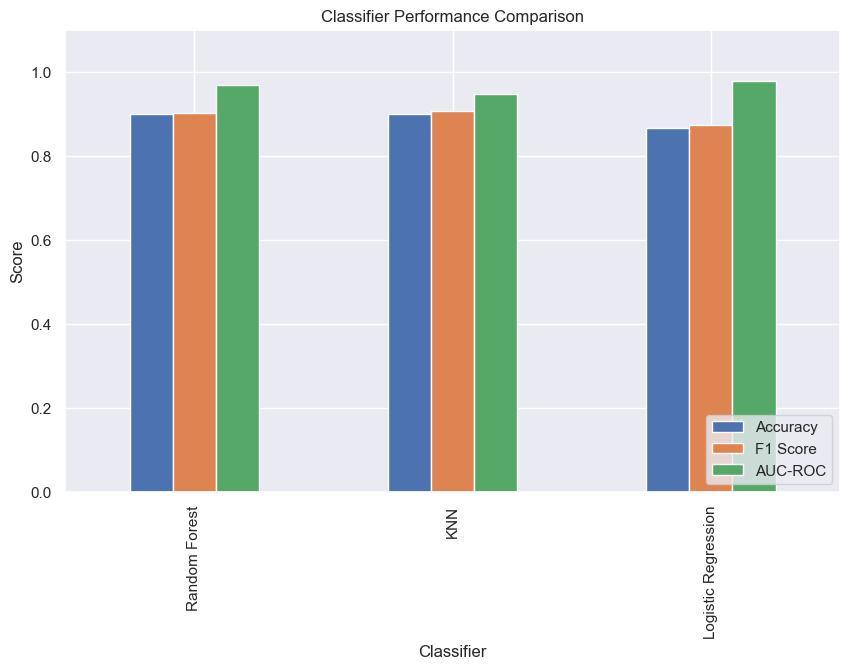

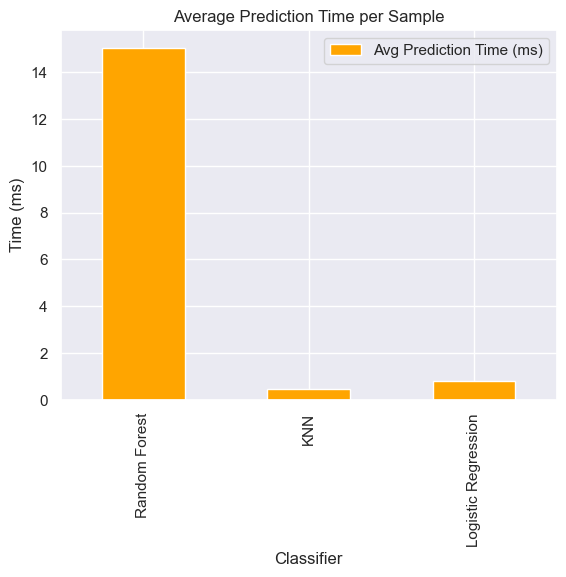

In [48]:
# Plot Accuracy, F1, AUC side by side
metrics = ['Accuracy', 'F1 Score', 'AUC-ROC']

results_df.plot(x='Classifier', y=metrics, kind='bar', figsize=(10,6))
plt.title('Classifier Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()

# Plot Prediction Time
results_df.plot(x='Classifier', y='Avg Prediction Time (ms)', kind='bar', color='orange')
plt.title('Average Prediction Time per Sample')
plt.ylabel('Time (ms)')
plt.show()
